# Code used to create ppu table
- table saved at ebmdatalab.outlier_detection.ppu_national_presentation_level

# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
GBQ_PROJECT_ID = '620265099307'

q = '''
SELECT
  month,
  bnf_code,
  SUM(ppu) AS ppu,
  SUM(quantity) AS quantity
FROM
  ebmdatalab.outlier_detection.ppu_national_presentation_level
GROUP BY
  month, bnf_code
ORDER BY
  bnf_code, month
'''
ppu = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ppu.head(3)

,month,bnf_code,ppu,quantity
0,2013-12-01,23965609635,5.666,850
1,2014-01-01,23965609635,5.666,470
2,2014-02-01,23965609635,5.666,590


In [2]:
df = ppu[['month','bnf_code','ppu']]
df = df.sort_values(['bnf_code','month'])
df = df.set_index(['bnf_code', 'month'])
df = df.unstack()
df.head(3)

ppu                                              \
month           2010-08-01 2010-09-01 2010-10-01 2010-11-01 2010-12-01   
bnf_code                                                                 
0101010C0AAAAAA   0.031264   0.031261   0.031264   0.031262   0.031263   
0101010C0AAACAC        NaN        NaN        NaN        NaN        NaN   
0101010C0AAAHAH        NaN        NaN        NaN        NaN        NaN   

                                                                        \
month           2011-01-01 2011-02-01 2011-03-01 2011-04-01 2011-05-01   
bnf_code                                                                 
0101010C0AAAAAA   0.038091   0.038092   0.038091    0.03809   0.038091   
0101010C0AAACAC        NaN        NaN        NaN        NaN        NaN   
0101010C0AAAHAH        NaN        NaN        NaN        NaN        NaN   

                   ...                                                  \
month              ...     2016-11-01 2016-12-01 2017-01-01 2017-02-01   
bnf_code           ...                                                   
0101010C0AAAAAA    ...       0.114256   0.114256   0.114257   0.114257   
0101010C0AAACAC    ...            NaN        NaN        NaN        NaN   
0101010C0AAAHAH    ...            NaN        NaN        NaN        NaN   

                                                                        \
month           2017-03-01 2017-04-01 2017-05-01 2017-06-01 2017-07-01   
bnf_code                                                                 
0101010C0AAAAAA   0.114256   0.114258    0.11426   0.114256   0.114256   
0101010C0AAACAC        NaN        NaN        NaN        NaN        NaN   
0101010C0AAAHAH        NaN        NaN        NaN        NaN        NaN   

                            
month           2017-08-01  
bnf_code                    
0101010C0AAAAAA   0.114256  
0101010C0AAACAC        NaN  
0101010C0AAAHAH        NaN  

[3 rows x 85 columns]

In [3]:
quantity = ppu[['bnf_code','month','quantity']]
quantity = quantity.sort_values(['bnf_code','month'])
quantity = quantity.set_index(['bnf_code', 'month'])
quantity = quantity.unstack()
quantity.columns = range(quantity.shape[1])
quantity.head(3)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
bnf_code,,,,,,,,,,,,,,,,,,,,,
0101010C0AAAAAA,31967.0,42326.0,34780.0,38484.0,35777.0,35160.0,31664.0,34220.0,31867.0,35046.0,...,16290.0,26066.0,19605.0,17784.0,21539.0,17888.0,18461.0,19701.0,18034.0,18559.0
0101010C0AAACAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0101010C0AAAHAH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
q = '''
SELECT
  presentation_code as bnf_code,
  presentation
FROM
  ebmdatalab.hscic.bnf
ORDER BY
  bnf_code
'''
bnf_names = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
bnf_names.head(3)

,bnf_code,presentation
0,010101000BBABA0,Langdales_Cinnamon Tab
1,010101000BBADA0,Mylanta 11_Tab
2,010101000BBAEA0,Mylanta 11_Liq


# CUSUM

In [5]:
months_smoothing = 12
sensitivity = 5

# remove date labels from columns
dates = df.columns #save date labels for later
df.columns = range(df.shape[1])

# create necessary tables with same index
smax = pd.DataFrame(index=df.index)
smin = pd.DataFrame(index=df.index)
reference_value = pd.DataFrame(index=df.index)
threshold = pd.DataFrame(index=df.index)
alert = pd.DataFrame(index=df.index)
not_alert = pd.DataFrame(index=df.index)

# set initial values for s
smax[0] = 0
smin[0] = 0

# set initial reference value for each 
reference_value[0] = df.loc[:,0:months_smoothing-1].mean(axis=1)
#set initial threshold
threshold[0] = df.loc[:,0:months_smoothing-1].std(axis=1, ddof=0) * sensitivity

# loop over months of data
for i in range(1,df.shape[1]):
    
    # logic to determine alerts from previous month
    alert = (smax[i-1] > threshold[i-1]) | (smin[i-1] < -threshold[i-1])
    not_alert = (smax[i-1] <= threshold[i-1]) & (smin[i-1] >= -threshold[i-1])
    ## I'm sure there's a way of doing without this ^ one,
        # just coudn't work out the syntax to slice pandas rows
        # based on the opposite of the array of boolean values
        
    # reference value and threshold:
    ##append previous value if no alert
    reference_value.loc[not_alert, i] = reference_value.loc[not_alert, i-1]
    threshold[i] = threshold[i-1]
    
    ## reset reference after alert
    reference_value.loc[alert, i] = df.loc[alert,i-months_smoothing:i-1].mean(axis=1)
    
    # CUSUM calculation (adding on previous s values done elsewhere)
    ##threshold[[i]] / sensitivity is a way of deriving stdev without generating it again
    smax[i] = df[i] - (reference_value[i] + (0.5 * threshold[i] / sensitivity))
    smin[i] = df[i] - (reference_value[i] - (0.5 * threshold[i] / sensitivity))
    
    # retrigger logic
    retrigger_pos = (smax[i] > 0) & (smax[i-1] > threshold[i-1])
    retrigger_neg = (smin[i] < 0) & (smin[i-1] < -threshold[i-1])
    cont_cumulative = not_alert|retrigger_pos|retrigger_neg
    thres_res = alert!=retrigger_pos|retrigger_neg
    
    # reset threshold
    threshold.loc[thres_res, i] = df.loc[thres_res,i-months_smoothing:i-1].std(axis=1, ddof=0) * sensitivity
    
    # add s from previous month if no trigger, or retrigger
    smax.loc[cont_cumulative, i] = smax.loc[cont_cumulative, i] + smax.loc[cont_cumulative, i-1]
    smin.loc[cont_cumulative, i] = smin.loc[cont_cumulative, i] + smin.loc[cont_cumulative, i-1]
    
    # set baselines of zero
    smax.loc[smax[i] < 0, i] = 0
    smin.loc[smin[i] > 0, i] = 0

# determine &export alerts
alert_pos = (smax > threshold)
alert_pos.to_csv('alert_pos_pandas.csv')

alert_neg = (smin < -threshold)
alert_neg.to_csv('alert_neg_pandas.csv')

df.head(3)
# other potentially useful outputs (for drawing graphs etc)
#smax
#smin
#value
#reference_value
#threshold

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
bnf_code,,,,,,,,,,,,,,,,,,,,,
0101010C0AAAAAA,0.031264,0.031261,0.031264,0.031262,0.031263,0.038091,0.038092,0.038091,0.03809,0.038091,...,0.114256,0.114256,0.114257,0.114257,0.114256,0.114258,0.11426,0.114256,0.114256,0.114256
0101010C0AAACAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0101010C0AAAHAH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Sparklines code

In [6]:
import base64
import requests
from time import sleep
from itertools import chain
from cStringIO import StringIO
from datetime import timedelta, date
from IPython.display import display, HTML

%pylab inline

# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

def sparkline(data, figsize=(4, 0.25), **kwags):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])    

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    
    img = StringIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()))

Populating the interactive namespace from numpy and matplotlib


# Determine size and duration of change

In [69]:
change_from = reference_value.copy()
change = pd.DataFrame(index=df.index)
change[0] = 0.0
change_proportion = pd.DataFrame(index=df.index)
change_proportion[0] = 0.0
duration = pd.DataFrame(index=df.index)
duration[0] = 0

for i in range(1,df.shape[1]):
    change_from[i].loc[(smax[i]!=0) | (smin[i]!=0)] = change_from[i-1]
    
    change[i] = (change_from[i] * quantity[i]) - (change_from[i-1] * quantity[i])
    change_proportion[i] = (change_from[i] - change_from[i-1]) /change_from[i-1]
    
    duration[i] = 1
    duration[i].loc[(smax[i-1]>0.0001) | (smin[i-1]<-0.0001)] = duration[i-1] +1

In [11]:
# Test
spl = ppu[['month','bnf_code','ppu']]
spl = spl.sort_values(['bnf_code','month']).head(85)
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})

HTML(spl.to_html(escape=False))

,ppu
bnf_code,
0101010C0AAAAAA,


In [86]:
change.columns = dates
change_proportion.columns = dates
duration.columns = dates

output = change.stack().reset_index()
output = output.merge(change_proportion.stack().reset_index(),
                      how='left',
                      on=['bnf_code','month'])
output = output.merge(duration.stack().reset_index(),
                      how='left',
                      on=['bnf_code','month'])
output.columns = ['bnf_code','month','cost_change','proportion_change','duration']
output = output.merge(bnf_names,
                      how='left',
                      on='bnf_code')

output = output.set_index(['bnf_code'])

pd.options.display.float_format = '{:,.2f}'.format
#output.loc[output['duration']<5].sort_values(by='cost_change',ascending=False)
output.head()

,month,cost_change,proportion_change,duration,presentation
bnf_code,,,,,
0101010C0AAAAAA,2010-08-01,0.00,0.00,0,Alum Hydrox_Cap 475mg
0101010C0AAAAAA,2010-09-01,0.00,0.00,1,Alum Hydrox_Cap 475mg
0101010C0AAAAAA,2010-10-01,0.00,0.00,2,Alum Hydrox_Cap 475mg
0101010C0AAAAAA,2010-11-01,0.00,0.00,3,Alum Hydrox_Cap 475mg
0101010C0AAAAAA,2010-12-01,0.00,0.00,4,Alum Hydrox_Cap 475mg


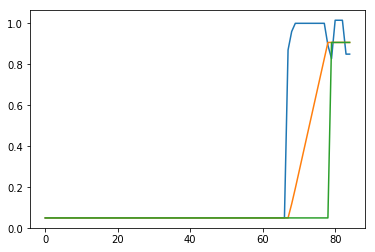

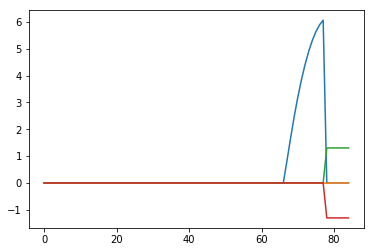

In [80]:
import matplotlib.pyplot as plt
measure = '0603010I0AAACAC'
plt.plot(df.loc[measure])
plt.plot(reference_value.loc[measure])
plt.plot(change_from.loc[measure])

plt.show()

plt.plot(smax.loc[measure])
plt.plot(smin.loc[measure])
plt.plot(threshold.loc[measure])
plt.plot(-threshold.loc[measure])
plt.show()

In [ ]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#    print(smax.loc['0406000B0AAABAB'])

# Results
Duration is pretty buggy at the moment -- take with a pinch of salt

## 1. Sorted by total cost to NHS
### Increase

In [87]:
output2 = output.sort_values(by='cost_change',
                           ascending=False).head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0603020J0AAADAD,2016-08-01,"2,657,080.21",0.91,60,Hydrocort_Tab 10mg,
0401010T0AAAMAM,2014-12-01,"1,804,867.02",7.45,27,Temazepam_Tab 10mg,
0408010Q0AAAAAA,2015-05-01,"1,512,273.90",18.08,18,Phenytoin_Sod Cap 100mg,
0602010M0AAAAAA,2017-03-01,"1,469,460.77",1.52,29,Liothyronine Sod_Tab 20mcg,
0403030Q0AAABAB,2013-11-01,"1,298,762.97",1.63,9,Sertraline HCl_Tab 100mg,
0603010I0AAACAC,2017-03-01,"1,158,107.24",16.96,13,Fludrocort Acet_Tab 100mcg,
0403010X0AAAFAF,2017-01-01,"1,103,563.39",3.99,46,Trazodone HCl_Oral Liq 50mg/5ml S/F,
0409020S0AAAEAE,2016-10-01,"1,032,235.68",6.28,13,Procyclidine HCl_Tab 5mg,
0403010V0AAADAD,2015-08-01,"975,729.32",2.23,38,Nortriptyline_Tab 10mg,


### Decrease

In [90]:
output2 = output.sort_values(by='cost_change').head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0212000B0AAABAB,2017-07-01,"-36,543,247.51",-0.96,62,Atorvastatin_Tab 20mg,
0212000B0AAACAC,2015-08-01,"-17,554,616.11",-0.94,39,Atorvastatin_Tab 40mg,
090401000BBMZA0,2012-03-01,"-14,756,129.57",-0.78,19,Fortijuce_S/Pack Liq,
0212000B0AAAAAA,2015-07-01,"-7,623,230.81",-0.91,38,Atorvastatin_Tab 10mg,
0411000D0AAABAB,2014-09-01,"-6,258,676.20",-0.98,1,Donepezil HCl_Tab 10mg,
0212000B0AAADAD,2014-11-01,"-5,608,633.09",-0.91,30,Atorvastatin_Tab 80mg,
0704050Z0AAACAC,2015-07-01,"-4,267,710.85",-0.95,44,Sildenafil_Tab 100mg,
040201060AAACAC,2013-05-01,"-4,155,314.09",-0.96,17,Olanzapine_Tab 10mg,
0303020G0AAABAB,2014-12-01,"-3,994,660.17",-0.91,18,Montelukast_Tab 10mg,


## 2. Sorted by total cost to NHS/filtered to short duration
### Increase

In [88]:
output2 = output.loc[output['duration']<=6].sort_values(by='cost_change',
                                                       ascending=False).head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0406000B0AAABAB,2013-03-01,"650,633.51",4.62,1,Betahistine HCl_Tab 16mg,
0501130R0AAAAAA,2016-12-01,"621,392.99",5.20,1,Nitrofurantoin_Cap 50mg,
0604020B0AAAAAA,2013-12-01,"329,478.33",0.50,1,Dutasteride_Cap 500mcg,
0408010Q0AAAPAP,2014-12-01,"272,285.10",22.83,1,Phenytoin_Sod Cap 50mg,
0801030L0AAAAAA,2013-11-01,"223,051.25",1.24,1,Mercaptopurine_Tab 50mg,
0901011F0AAAEAE,2015-02-01,"210,799.37",0.90,1,Ferr Fumar_Tab 210mg,
0603020T0AABHBH,2017-02-01,"174,881.89",0.25,1,Prednisolone_Tab Solb 5mg,
0604011D0AAAAAA,2016-09-01,"145,600.34",2.56,1,Ethinylestr_Tab 10mcg,
0403010B0AAAGAG,2015-09-01,"145,290.49",0.15,1,Amitriptyline HCl_Tab 10mg,


### Decrease

In [91]:
output2 = output.loc[output['duration']<=6].sort_values(by='cost_change').head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0411000D0AAABAB,2014-09-01,"-6,258,676.20",-0.98,1,Donepezil HCl_Tab 10mg,
0205052I0AAABAB,2014-12-01,"-963,959.13",-0.86,1,Irbesartan_Tab 150mg,
0703021Q0AAAAAA,2017-04-01,"-926,699.53",-0.75,1,Desogestrel_Tab 75mcg,
0208020X0AAABAB,2014-11-01,"-710,111.68",-0.48,1,Dabigatran Etexilate_Cap 110mg,
0604020B0AAAAAA,2016-12-01,"-417,069.53",-0.51,1,Dutasteride_Cap 500mcg,
0302000N0BCAAAX,2013-09-01,"-224,863.30",-0.42,2,Seretide 100_Accuhaler 100mcg/50mcg(60D),
0601060D0BHABA0,2015-05-01,"-184,680.99",-0.19,1,OneTouch Ultra (Reagent)_Strips,
1108010B0BBAAAB,2015-03-01,"-142,166.07",-0.46,1,Viscotears_Liq Gel 2mg/g,
0411000D0AAAEAE,2016-04-01,"-138,981.34",-0.89,1,Donepezil HCl_Orodisper Tab 10mg S/F,


## 3. Sorted by proportional PPU change
### Increase

In [89]:
output2 = output.sort_values(by='proportion_change',
                           ascending=False).head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
1307000J0AAABAB,2012-09-01,459.32,135.05,11,Podoph_Paint BPC 1954,
0304010I0BFABAB,2013-04-01,148.67,70.47,15,Piriteze_Allergy Syr 1mg/1ml S/F,
0202010F0AAAAAA,2017-04-01,"80,002.89",49.81,39,Chlortalidone_Tab 50mg,
0401010R0AAAAAA,2017-01-01,"179,672.85",45.09,15,Nitrazepam_Oral Susp 2.5mg/5ml,
0407020H0AAABAB,2016-10-01,"171,110.67",35.88,64,Dipipanone HCl/Cyclizine HCl_Tab 10/30mg,
0906024N0AAANAN,2013-12-01,"8,756.18",32.05,19,Pyridox HCl_Tab 20mg,
0401010B0AAAFAF,2016-09-01,"96,053.00",26.70,27,Chloral Hydrate_Oral Soln 143mg/5ml BP,
0403010L0AAACAC,2017-03-01,"258,659.91",26.25,34,Doxepin_Cap 50mg,
0403010L0AAABAB,2017-03-01,"291,675.37",24.99,35,Doxepin_Cap 25mg,


### Decrease

In [92]:
output2 = output.sort_values(by='proportion_change').head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
040201060AAAQAQ,2016-11-01,"-1,977,652.89",-0.99,61,Olanzapine_Tab 20mg,
040201060AAALAL,2015-12-01,"-1,162,305.70",-0.98,50,Olanzapine_Tab 15mg,
0411000D0AAABAB,2014-09-01,"-6,258,676.20",-0.98,1,Donepezil HCl_Tab 10mg,
0402010ABAAAFAF,2015-02-01,"-720,583.19",-0.97,33,Quetiapine_Tab 150mg,
0411000D0AAAAAA,2016-01-01,"-1,664,577.13",-0.97,45,Donepezil HCl_Tab 5mg,
0402010ABAAAKAK,2015-03-01,"-1,515,552.49",-0.97,35,Quetiapine_Tab 300mg,
040201060AAAAAA,2015-03-01,"-1,862,382.39",-0.97,39,Olanzapine_Tab 5mg,
0411000G0AAADAD,2016-11-01,"-2,471,407.40",-0.97,37,Memantine HCl_Tab 20mg,
0402010ABAAADAD,2015-10-01,"-1,729,614.40",-0.97,41,Quetiapine_Tab 200mg,


## 4. Sorted by proportional PPU change/filtered by short duration
### Increase

In [93]:
output2 = output.loc[output['duration']<=6].sort_values(by='proportion_change',
                                                       ascending=False).head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0408010Q0AAAPAP,2014-12-01,"272,285.10",22.83,1,Phenytoin_Sod Cap 50mg,
0102000J0AAAAAA,2013-06-01,"62,445.64",15.20,3,Dicycloverine HCl_Oral Soln 10mg/5ml,
0304010G0BKAAAC,2013-08-01,341.04,11.00,1,Hayleve_Tab 4mg,
0607030M0BBAAAA,2014-09-01,"2,925.76",7.78,6,Metopirone_Cap 250mg,
0403010Y0AAACAC,2014-12-01,"125,977.98",6.35,1,Trimipramine Mal_Tab 25mg,
090607000BBCFAZ,2014-04-01,"15,110.07",6.07,1,Ketovite_Supp Liq S/F,
0402020G0BBAGAI,2015-09-01,"8,553.23",5.49,1,Depixol Low Volume_Inj 200mg/ml 1ml Amp,
0501130R0AAAAAA,2016-12-01,"621,392.99",5.20,1,Nitrofurantoin_Cap 50mg,
0406000B0AAABAB,2013-03-01,"650,633.51",4.62,1,Betahistine HCl_Tab 16mg,


### Decrease

In [98]:
output2 = output.loc[output['duration']<=6].sort_values(by='proportion_change').head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0411000D0AAABAB,2014-09-01,"-6,258,676.20",-0.98,1,Donepezil HCl_Tab 10mg,
0411000D0AAAEAE,2016-04-01,"-138,981.34",-0.89,1,Donepezil HCl_Orodisper Tab 10mg S/F,
0205052I0AAABAB,2014-12-01,"-963,959.13",-0.86,1,Irbesartan_Tab 150mg,
0503021C0BBAEAE,2014-02-01,"-2,300.50",-0.84,1,Zovirax_Tab Disper 800mg,
0503021C0BBAGAG,2015-12-01,"-1,779.62",-0.84,1,Zovirax_Tab Disper 200mg,
0309010X0AAARAR,2016-10-01,-616.98,-0.83,1,Pholcodine_Oral Soln 2mg/5ml S/F,
0703021Q0AAAAAA,2017-04-01,"-926,699.53",-0.75,1,Desogestrel_Tab 75mcg,
0401010Y0BBAAAA,2015-07-01,"-1,142.25",-0.63,1,Stilnoct_Tab 5mg,
20030800150,2015-11-01,-270.90,-0.60,1,NaN,


## 5. Sorted by proportional PPU change/filtered by short duration AND >£10,000
### Increase

In [96]:
output2 = output.loc[(output['duration']<=6)&(output['cost_change']>10000)].sort_values(by='proportion_change',
                                                       ascending=False).head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0408010Q0AAAPAP,2014-12-01,"272,285.10",22.83,1,Phenytoin_Sod Cap 50mg,
0102000J0AAAAAA,2013-06-01,"62,445.64",15.20,3,Dicycloverine HCl_Oral Soln 10mg/5ml,
0403010Y0AAACAC,2014-12-01,"125,977.98",6.35,1,Trimipramine Mal_Tab 25mg,
090607000BBCFAZ,2014-04-01,"15,110.07",6.07,1,Ketovite_Supp Liq S/F,
0501130R0AAAAAA,2016-12-01,"621,392.99",5.20,1,Nitrofurantoin_Cap 50mg,
0406000B0AAABAB,2013-03-01,"650,633.51",4.62,1,Betahistine HCl_Tab 16mg,
1304000F0AACACA,2014-05-01,"18,993.58",4.39,1,Betameth Val/Clioquinol_Crm 0.1%/3%,
0604020K0AABKBK,2015-05-01,"19,978.27",4.00,1,Testosterone_Gel 50mg/5g Ud Tube,
0901011W0BBAAAA,2017-06-01,"60,819.09",2.57,1,Sytron_Elix 190mg/5ml S/F,


### Decrease

In [101]:
output2 = output.loc[(output['duration']<=6)&(output['cost_change']<-10000)].sort_values(by='proportion_change').head(20)
spl = output2.merge(ppu[['month','bnf_code','ppu']],
                    how='left',
                    left_index=True,
                    right_on='bnf_code')
spl = spl.groupby(['bnf_code']).aggregate({'ppu': sparkline})
output2 = output2.merge(spl,
                      how='left',
                      left_index=True,
                      right_index=True)

HTML(output2.to_html(escape=False))

,month,cost_change,proportion_change,duration,presentation,ppu
bnf_code,,,,,,
0411000D0AAABAB,2014-09-01,"-6,258,676.20",-0.98,1,Donepezil HCl_Tab 10mg,
0411000D0AAAEAE,2016-04-01,"-138,981.34",-0.89,1,Donepezil HCl_Orodisper Tab 10mg S/F,
0205052I0AAABAB,2014-12-01,"-963,959.13",-0.86,1,Irbesartan_Tab 150mg,
0703021Q0AAAAAA,2017-04-01,"-926,699.53",-0.75,1,Desogestrel_Tab 75mcg,
0604020B0AAAAAA,2016-12-01,"-417,069.53",-0.51,1,Dutasteride_Cap 500mcg,
0208020X0AAAAAA,2014-10-01,"-25,978.65",-0.48,2,Dabigatran Etexilate_Cap 75mg,
0208020X0BBABAB,2014-09-01,"-15,375.68",-0.48,1,Pradaxa_Cap 110mg,
0208020X0AAABAB,2014-11-01,"-710,111.68",-0.48,1,Dabigatran Etexilate_Cap 110mg,
1108010B0BBAAAB,2015-03-01,"-142,166.07",-0.46,1,Viscotears_Liq Gel 2mg/g,
